In [70]:
import itertools
import joblib
import lightgbm as lgbm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.feature_selection import VarianceThreshold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

In [2]:
df_features = pd.read_csv('./all_features_BR.csv', index_col=False)

In [3]:
df_features.head()

,spectral_centroid_max,spectral_centroid_min,spectral_centroid_mean,spectral_centroid_std,spectral_centroid_kurtosis,spectral_centroid_skew,spectral_rolloff_max,spectral_rolloff_min,spectral_rolloff_mean,spectral_rolloff_std,...,mfcc_11_kurtosis,mfcc_11_skew,mfcc_12_max,mfcc_12_min,mfcc_12_mean,mfcc_12_std,mfcc_12_kurtosis,mfcc_12_skew,tempo,label
0,4737.508153,635.664676,2098.726133,556.496663,2.887029,1.283600,9130.078125,925.927734,4514.561770,1372.578815,...,-0.086715,-0.088010,32.658615,-31.948511,-5.576648,9.920987,-0.200280,0.234563,143.554688,forró
1,5339.076724,1019.369702,2294.895607,604.767987,1.803070,0.943630,9130.078125,1722.656250,4914.999411,1341.457851,...,0.120776,-0.207388,21.607838,-36.618702,-4.257775,9.034795,-0.080838,0.118976,143.554688,forró
2,6613.348219,1526.374864,2857.957595,685.797071,3.499504,1.245568,9474.609375,2648.583984,6027.380220,1304.601244,...,-0.253195,0.186958,32.782486,-35.293335,-7.233448,11.249509,-0.106279,0.236294,151.999081,forró
3,6935.364306,945.116845,2439.278264,730.595169,4.671441,1.223784,9840.673828,1184.326172,5551.766429,1564.960933,...,0.052664,-0.347261,28.608442,-36.924840,-3.531663,9.956684,0.135261,-0.020543,107.666016,forró
4,7086.838756,928.772862,2541.888664,744.284935,2.716824,1.082830,9969.873047,1162.792969,6118.729668,1422.390345,...,-0.254407,-0.014688,29.134048,-33.681553,-3.894992,9.132825,0.035545,0.014757,135.999178,forró


In [4]:
X = df_features.drop(['label'], axis=1).values

In [5]:
y = df_features['label'].values

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y)

# Regressão Logística

In [7]:
params_lr = {
    'cls__penalty': ['l2', 'none'],
    'cls__C': [0.5, 1, 2, 5],
    'cls__max_iter': [500, 1000]
}

In [8]:
pipeline_lr = Pipeline([
    ('scale', StandardScaler()),
    ('var_threshold', VarianceThreshold(threshold=(.8 * (1 - .8)))),
    ('feature_selection', SelectFromModel(lgbm.LGBMClassifier())),
    ('cls', LogisticRegression())
])

In [9]:
grid_lr = GridSearchCV(pipeline_lr, params_lr, scoring='accuracy', n_jobs=6, cv=5)

In [10]:
grid_lr.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scale', StandardScaler()),
                                       ('var_threshold',
                                        VarianceThreshold(threshold=0.15999999999999998)),
                                       ('feature_selection',
                                        SelectFromModel(estimator=LGBMClassifier())),
                                       ('cls', LogisticRegression())]),
             n_jobs=6,
             param_grid={'cls__C': [0.5, 1, 2, 5], 'cls__max_iter': [500, 1000],
                         'cls__penalty': ['l2', 'none']},
             scoring='accuracy')

In [11]:
predictions_lr = grid_lr.predict(X_test)

In [12]:
print(f"Melhor score no conjunto de validação (acurácia) = {grid_lr.best_score_}")
print(f"Melhor score no conjunto de teste (acurácia) = {accuracy_score(y_test, predictions_lr)}")

Melhor score no conjunto de validação (acurácia) = 0.7619428571428571
Melhor score no conjunto de teste (acurácia) = 0.8038277511961722


In [13]:
grid_lr.best_params_

{'cls__C': 1, 'cls__max_iter': 500, 'cls__penalty': 'l2'}

# Árvore de Decisão

In [14]:
params_dt = {
    'cls__criterion': ['gini', 'entropy'],
    'cls__splitter': ['best', 'random'],
}

In [15]:
pipeline_dt = Pipeline([
    ('var_threshold', VarianceThreshold(threshold=(.8 * (1 - .8)))),
    ('feature_selection', SelectFromModel(lgbm.LGBMClassifier())),
    ('cls', DecisionTreeClassifier())
])

In [16]:
grid_dt = GridSearchCV(pipeline_dt, params_dt, scoring='accuracy', n_jobs=6, cv=5)

In [17]:
grid_dt.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('var_threshold',
                                        VarianceThreshold(threshold=0.15999999999999998)),
                                       ('feature_selection',
                                        SelectFromModel(estimator=LGBMClassifier())),
                                       ('cls', DecisionTreeClassifier())]),
             n_jobs=6,
             param_grid={'cls__criterion': ['gini', 'entropy'],
                         'cls__splitter': ['best', 'random']},
             scoring='accuracy')

In [18]:
predictions_dt = grid_dt.predict(X_test)

In [19]:
print(f"Melhor score no conjunto de validação (acurácia) = {grid_dt.best_score_}")
print(f"Melhor score no conjunto de teste (acurácia) = {accuracy_score(y_test, predictions_dt)}")

Melhor score no conjunto de validação (acurácia) = 0.5543365079365079
Melhor score no conjunto de teste (acurácia) = 0.5645933014354066


In [20]:
grid_dt.best_params_

{'cls__criterion': 'gini', 'cls__splitter': 'best'}

# Floresta Aleatória

In [21]:
params_rf = {
    "cls__n_estimators": [100, 250, 500, 1000],
    "cls__criterion": ["gini", "entropy"],
    "cls__max_depth": [5, 7, None]
}

In [22]:
pipeline_rf = Pipeline([
    ('var_threshold', VarianceThreshold(threshold=(.8 * (1 - .8)))),
    ('feature_selection', SelectFromModel(lgbm.LGBMClassifier())),
    ('cls', RandomForestClassifier())
])

In [23]:
grid_rf = GridSearchCV(pipeline_rf, params_rf, scoring='accuracy', n_jobs=6, cv=5)

In [24]:
grid_rf.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('var_threshold',
                                        VarianceThreshold(threshold=0.15999999999999998)),
                                       ('feature_selection',
                                        SelectFromModel(estimator=LGBMClassifier())),
                                       ('cls', RandomForestClassifier())]),
             n_jobs=6,
             param_grid={'cls__criterion': ['gini', 'entropy'],
                         'cls__max_depth': [5, 7, None],
                         'cls__n_estimators': [100, 250, 500, 1000]},
             scoring='accuracy')

In [25]:
predictions_rf = grid_rf.predict(X_test)

In [26]:
print(f"Melhor score no conjunto de validação (acurácia) = {grid_rf.best_score_}")
print(f"Melhor score no conjunto de teste (acurácia) = {accuracy_score(y_test, predictions_rf)}")

Melhor score no conjunto de validação (acurácia) = 0.7572063492063492
Melhor score no conjunto de teste (acurácia) = 0.7416267942583732


In [27]:
grid_rf.best_params_

{'cls__criterion': 'entropy', 'cls__max_depth': None, 'cls__n_estimators': 250}

# SVM

In [28]:
params_svm = {
    "cls__C": [0.5, 1, 2, 5],
    "cls__kernel": ['rbf', 'linear', 'sigmoid'],
}

In [29]:
pipeline_svm = Pipeline([
    ('scale', StandardScaler()),
    ('var_threshold', VarianceThreshold(threshold=(.8 * (1 - .8)))),
    ('feature_selection', SelectFromModel(lgbm.LGBMClassifier())),
    ('cls', SVC())
])

In [30]:
grid_svm = GridSearchCV(pipeline_svm, params_svm, scoring='accuracy', n_jobs=6, cv=5)

In [31]:
grid_svm.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scale', StandardScaler()),
                                       ('var_threshold',
                                        VarianceThreshold(threshold=0.15999999999999998)),
                                       ('feature_selection',
                                        SelectFromModel(estimator=LGBMClassifier())),
                                       ('cls', SVC())]),
             n_jobs=6,
             param_grid={'cls__C': [0.5, 1, 2, 5],
                         'cls__kernel': ['rbf', 'linear', 'sigmoid']},
             scoring='accuracy')

In [32]:
predictions_svm = grid_svm.predict(X_test)

In [33]:
print(f"Melhor score no conjunto de validação (acurácia) = {grid_svm.best_score_}")
print(f"Melhor score no conjunto de teste (acurácia) = {accuracy_score(y_test, predictions_svm)}")

Melhor score no conjunto de validação (acurácia) = 0.7955428571428571
Melhor score no conjunto de teste (acurácia) = 0.7990430622009569


In [34]:
grid_svm.best_params_

{'cls__C': 1, 'cls__kernel': 'rbf'}

# K Vizinhos

In [35]:
params_knn = {
    "cls__n_neighbors": [1, 2, 5, 10],
    "cls__weights": ['uniform', 'distance'],
    "cls__algorithm": ['auto', 'ball_tree', 'kd_tree', 'brute']
}

In [36]:
pipeline_knn = Pipeline([
    ('scale', StandardScaler()),
    ('var_threshold', VarianceThreshold(threshold=(.8 * (1 - .8)))),
    ('feature_selection', SelectFromModel(lgbm.LGBMClassifier())),
    ('cls', KNeighborsClassifier())
])

In [37]:
grid_knn = GridSearchCV(pipeline_knn, params_knn, scoring='accuracy', n_jobs=6, cv=5)

In [38]:
grid_knn.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scale', StandardScaler()),
                                       ('var_threshold',
                                        VarianceThreshold(threshold=0.15999999999999998)),
                                       ('feature_selection',
                                        SelectFromModel(estimator=LGBMClassifier())),
                                       ('cls', KNeighborsClassifier())]),
             n_jobs=6,
             param_grid={'cls__algorithm': ['auto', 'ball_tree', 'kd_tree',
                                            'brute'],
                         'cls__n_neighbors': [1, 2, 5, 10],
                         'cls__weights': ['uniform', 'distance']},
             scoring='accuracy')

In [39]:
predictions_knn = grid_knn.predict(X_test)

In [40]:
print(f"Melhor score no conjunto de validação (acurácia) = {grid_knn.best_score_}")
print(f"Melhor score no conjunto de teste (acurácia) = {accuracy_score(y_test, predictions_knn)}")

Melhor score no conjunto de validação (acurácia) = 0.7347555555555555
Melhor score no conjunto de teste (acurácia) = 0.7416267942583732


In [41]:
grid_knn.best_params_

{'cls__algorithm': 'auto', 'cls__n_neighbors': 10, 'cls__weights': 'distance'}

# Naive Bayes

In [42]:
params_nb = {
    "cls__priors": [None],
    "cls__var_smoothing": [1e-7, 1e-8, 1e-9]
}

In [43]:
pipeline_nb = Pipeline([
    ('scale', StandardScaler()),
    ('var_threshold', VarianceThreshold(threshold=(.8 * (1 - .8)))),
    ('feature_selection', SelectFromModel(lgbm.LGBMClassifier())),
    ('cls', GaussianNB())
])

In [44]:
grid_nb = GridSearchCV(pipeline_nb, params_nb, scoring='accuracy', n_jobs=6, cv=5)

In [45]:
grid_nb.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scale', StandardScaler()),
                                       ('var_threshold',
                                        VarianceThreshold(threshold=0.15999999999999998)),
                                       ('feature_selection',
                                        SelectFromModel(estimator=LGBMClassifier())),
                                       ('cls', GaussianNB())]),
             n_jobs=6,
             param_grid={'cls__priors': [None],
                         'cls__var_smoothing': [1e-07, 1e-08, 1e-09]},
             scoring='accuracy')

In [46]:
predictions_nb = grid_nb.predict(X_test)

In [47]:
print(f"Melhor score no conjunto de validação (acurácia) = {grid_nb.best_score_}")
print(f"Melhor score no conjunto de teste (acurácia) = {accuracy_score(y_test, predictions_nb)}")

Melhor score no conjunto de validação (acurácia) = 0.7060190476190477
Melhor score no conjunto de teste (acurácia) = 0.7416267942583732


In [48]:
grid_nb.best_params_

{'cls__priors': None, 'cls__var_smoothing': 1e-07}

In [55]:
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.

    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(
            j,
            i,
            format(cm[i, j], fmt),
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black"
        )

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

In [51]:
genres = df_features['label'].unique()

### Matriz de confusão da regressão logística

In [52]:
cm_lr = confusion_matrix(y_test, predictions_lr)

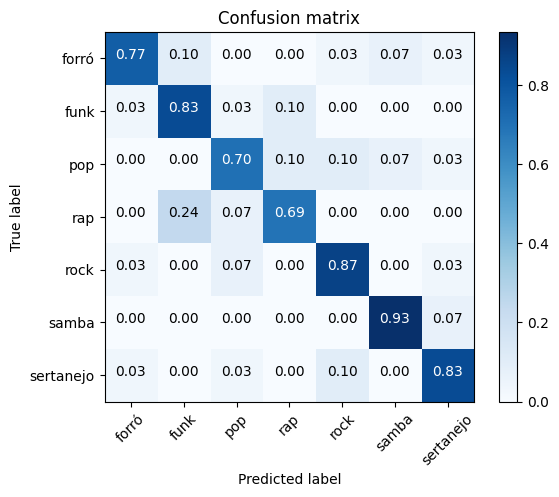

In [60]:
plot_confusion_matrix(cm_lr, genres, normalize=True)

### Matriz de confusão da árvore de decisão

In [61]:
cm_dt = confusion_matrix(y_test, predictions_dt)

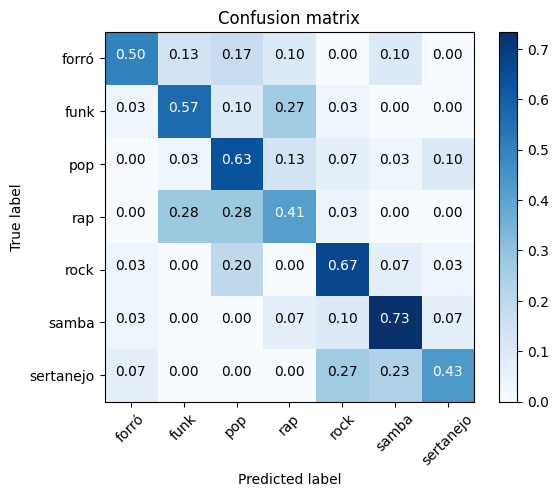

In [62]:
plot_confusion_matrix(cm_dt, genres, normalize=True)

### Matriz de confusão da floresta aleatória

In [63]:
cm_rf = confusion_matrix(y_test, predictions_rf)

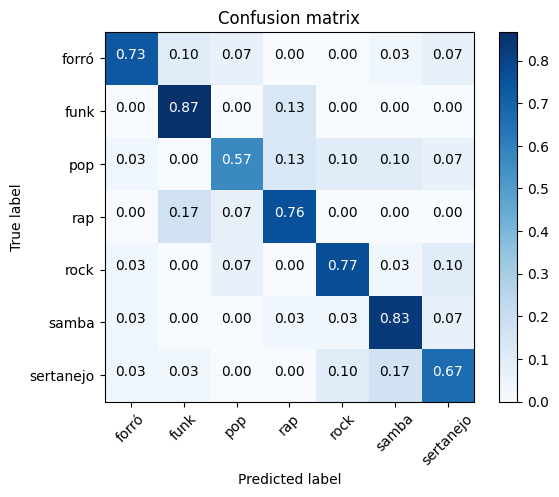

In [64]:
plot_confusion_matrix(cm_rf, genres, normalize=True)

### Matriz de confusão da SVM

In [65]:
cm_svm = confusion_matrix(y_test, predictions_svm)

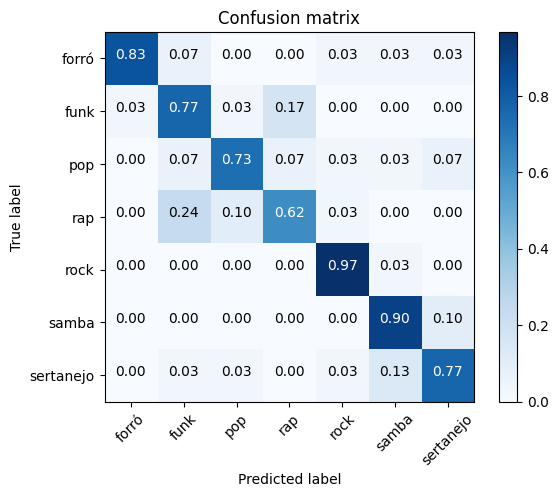

In [66]:
plot_confusion_matrix(cm_svm, genres, normalize=True)

### Matriz de confusão do K Vizinhos

In [67]:
cm_knn = confusion_matrix(y_test, predictions_knn)

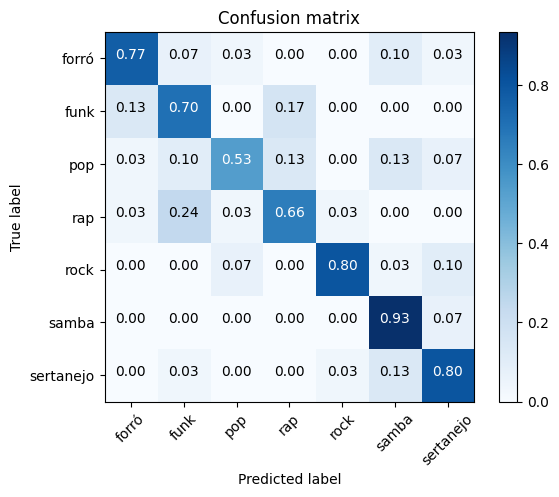

In [68]:
plot_confusion_matrix(cm_knn, genres, normalize=True)

### Matriz de confusão do Naive Bayes

In [71]:
cm_nb = confusion_matrix(y_test, predictions_nb)

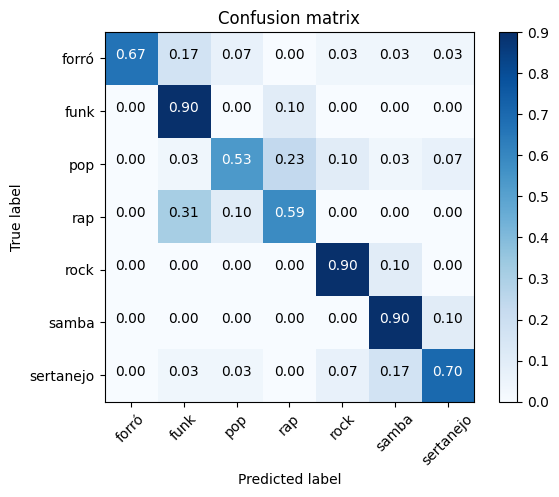

In [72]:
plot_confusion_matrix(cm_nb, genres, normalize=True)

In [75]:
joblib.dump(grid_lr, "./models/pipe_lr.joblib")
joblib.dump(grid_dt, "./models/pipe_dt.joblib")
joblib.dump(grid_rf, "./models/pipe_rf.joblib")
joblib.dump(grid_svm, "./models/pipe_svm.joblib")
joblib.dump(grid_knn, "./models/pipe_knn.joblib")
joblib.dump(grid_nb, "./models/pipe_nb.joblib")

['./models/pipe_nb.joblib']